In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

In [ ]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

In [ ]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv", index_col=0) 
df2=pd.read_csv("WBA.csv", index_col=0)  
df3=pd.read_csv("MTRAF.csv", index_col=0)
df4=pd.read_csv("COOP.csv", index_col=0) 
df5=pd.read_csv("JSAIY.csv", index_col=0)  
df6=pd.read_csv("ADRNY.csv", index_col=0)  
df7=pd.read_csv("TSCDY.csv", index_col=0)  
df8=pd.read_csv("KR.csv", index_col=0)    
df9=pd.read_csv("AGHC.csv", index_col=0)  
df10=pd.read_csv("CRRFY.csv", index_col=0) 
df11=pd.read_csv("WNGRF.csv", index_col=0) 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df3

# Make models (train)

In [ ]:
from keras.layers import *
def make_models(all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], output_vars=[2], 
                outputs_company=1, train_size=754, time_step=60, epochs=30, units=50, batch_size=64, volume_switch=False,): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  # Show arguments
  inputs=['-', 'Open', 'High', 'Low', 'Close', '-', 'Volume']
  print(f"[Arguments]") 
  print(f"num_company={len(company_list)}社 {company_list}")
  print(f"input_variables={input_category}, ====> output_variables={output_category}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}, batch_size={batch_size}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. normalise data
  #3. prepare both training_data and label depending on the number of inputs and outputs
  X_train=[]
  y_trains=[]
  

  training_set_all=np.hstack((data[:,:] for data in train_data))
  print(f"training_set_all={training_set_all.shape}") # (754, company_list * input_vars)
  
  ss_all=[]
  for i in range(training_set_all.shape[1]):
    ss1=StandardScaler()
    ss_all.append(ss1.fit_transform(training_set_all[:,i].reshape(-1, 1)))
  concat=np.hstack(ss_all)

  index=[]
  for i in range(len(output_vars)):
    index+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*(len(input_vars)), len(input_vars))] 
  print(index)
  
  for l in range(time_step, train_size):
    X_train.append(concat[l-time_step: l, :])
    for m in range(len(index)):
      y_trains.append(concat[l, index[m]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")

  #4. modify y_train based on the number of companies
  y_trains2=[]
  
  if len(output_vars) != 1:
    for x in range(len(all_data)*len(output_vars)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(all_data*len(output_vars)))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(all_data)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(all_data))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  #5. make models

  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=batch_size)
    model_lists.append(model)
    print("")

  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [ ]:
# Make predictions
def make_preds(model_lists, y_trains2, all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], 
               output_vars=[2], train_size=754, time_step=60, cm_switch=False, volume_switch=False):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")

  #1. Prepare test_data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  
  inputs = []
  for m in range(len(all_data)): 
    inputs.append(all_data[m].iloc[:, input_vars][len(all_data[m])-len(test_data[m])-time_step:].values)
  inputs = np.array(inputs)

  #2. normalise
  variables=[]
  ss=[]
  for i in range(len(all_data)):
    for j in range(len(input_vars)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # Use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])
  X_test = np.array(X_test)

  #3. make predictiions
  preds = [] 
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_vars)==1:
    ind=[i for i in range(input_vars.index(output_vars[0]), len(all_data)*len(input_vars), len(input_vars))]
  else:
    ind=[]
    for i in range(len(output_vars)):
      ind+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*len(input_vars), len(input_vars))]
 
  #4. scale_back normalise
  for p in range(len(y_trains2)):
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) 
  preds = np.array(preds)

  #5. plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_vars)):
    actual_lists_test+=[sc.iloc[train_size:,output_vars[dd]] for sc in all_data]
    actual_lists_train+=[sc.iloc[:train_size,output_vars[dd]] for sc in all_data]
  
  if len(output_vars) > 1:
    R2=company_list*len(output_vars) # lists of companies
  else: R2=company_list
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(all_data)-1, len(R2), len(all_data))]

  plt.figure(figsize=(18, 35))
  scores_list=[]
  for p in range(len(R2)):
    if len(company_list) >=9: plt.subplot(6, 2, p+1)
    else: plt.subplot(4, 2, p+1) 
    plt.plot(all_data[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(all_data[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(all_data[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    if input_vars[0]=="2": plt.ylabel('High Price')
    else: plt.ylabel('Volume')
    
    from sklearn.metrics import r2_score
    r2=round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)
    scores_list.append(r2)
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  # calcurate R2_average 
  if p in r:
    scores_list.append(round(R/len(all_data), 4))
    print(f"R2-{len(all_data)}companies_average={round(R/len(all_data), 4)}")
    R=0
  print(f"R2_scores_lists={scores_list}")
  print("")
  #6. Make confusion matrix
  columns = company_list # labeling 
  
  if cm_switch==True:
    for p in range(len(output_vars)):
      print(f"Preds_Heatmap='{output_category[p]}' correlation")
      prd=[preds[p] for p in range(len(company_list)*p, len(company_list)+p*len(company_list))]
      Preds= pd.DataFrame(np.concatenate(prd, axis=1))
      Preds.columns = columns
    
      plt.figure(figsize=(8, 6))
      cmap=sns.diverging_palette(220, 20, as_cmap=True)
      sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten() 


# 7月3日以降　


## ALL in ALL Function

In [ ]:
def multivariate_LSTM(original_all_data, num_company=11, input_category=['High'], input_vars=[2], output_category=['High'], output_vars=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50, batch_size=64, cm_switch=False):
  
  """Define variables
  original_all_data: Financial data of all companies used
  num_company: Number of companies to be randomly selected from all companies
  input_vars: The item number of the variable to be used as input (More than one can be specified)
  output_vategory: Category name of the variable to be output (More than one can be specified)
  output_vars: The item number of the variable to be used as outputs (More than one can be specified)
  """

  all_companies_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 
                      'Coop Group (Switzerland)', 'J.Sainsbury(Britain)', "Royal Ahold Delhaize(Netherlands)", 
                      "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

  # Pick up companies rondomly
  import random
  company_list=random.sample(all_companies_list, num_company) 
  all_data=[]
  for n in range(num_company):
    ind = all_companies_list.index(company_list[n])
    all_data.append(original_all_data[ind])
  
  # 　Check if the specified variable has "Volume" for training
  if 6 not in input_vars: volume_switch=False
  else: volume_switch=True

  # Make Models
  model_lists, y_trains = make_models(all_data, company_list, input_category, input_vars, output_category, 
                                      output_vars, outputs_company, train_size, time_step, epochs, units, batch_size, volume_switch)
  # Make Predictions           
  make_preds(model_lists, y_trains, all_data, company_list, input_category, input_vars, 
             output_category, output_vars, train_size, time_step, cm_switch, volume_switch)

# 関数完成チェック用(final)

In [ ]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
""" items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6} """

' items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6} '

# High -> High 

1回目
[Arguments]
num_company=2社 ['Carrefour(France)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.3801
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1424
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1012
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0865
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0947
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0843
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0717
Epoch 8/50
22/22 [==============================] - 0s 13ms/step - loss: 0

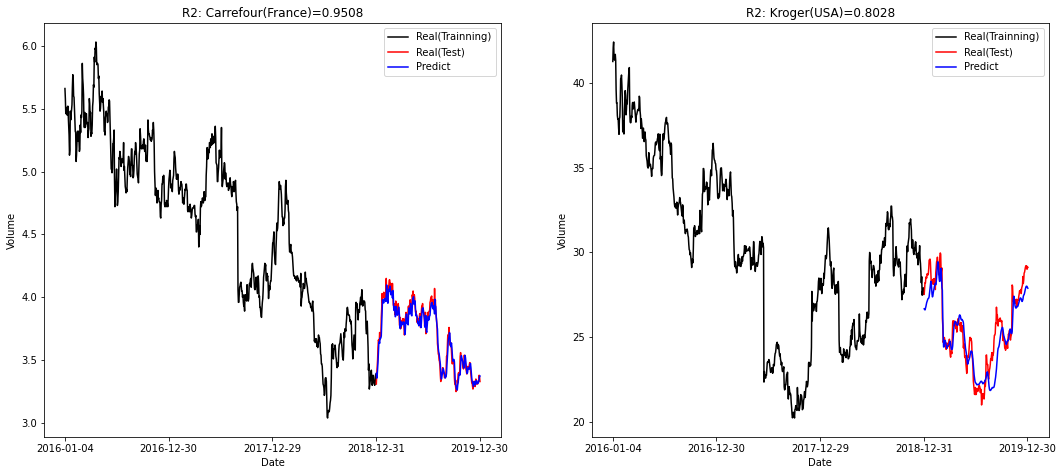

R2-2companies_average=0.8768
R2_scores_lists=[0.9508, 0.8028, 0.8768]

2回目
[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Tesco(Britain)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 5s 19ms/step - loss: 0.6748
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3680
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3060
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2749
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3077
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.2552
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss

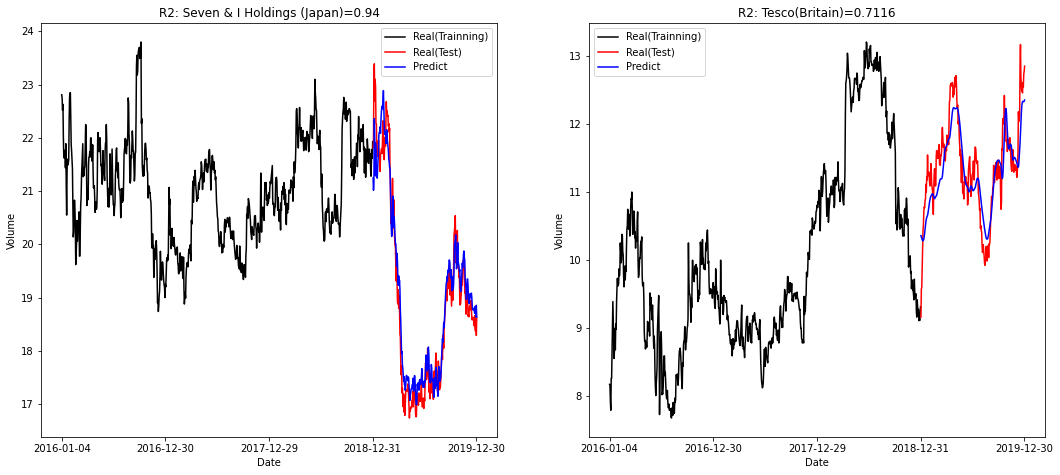

R2-2companies_average=0.8258
R2_scores_lists=[0.94, 0.7116, 0.8258]

3回目
[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 6s 20ms/step - loss: 0.5666
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1509
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1519
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1250
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1177
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1190
Epoch 7/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0869
Ep

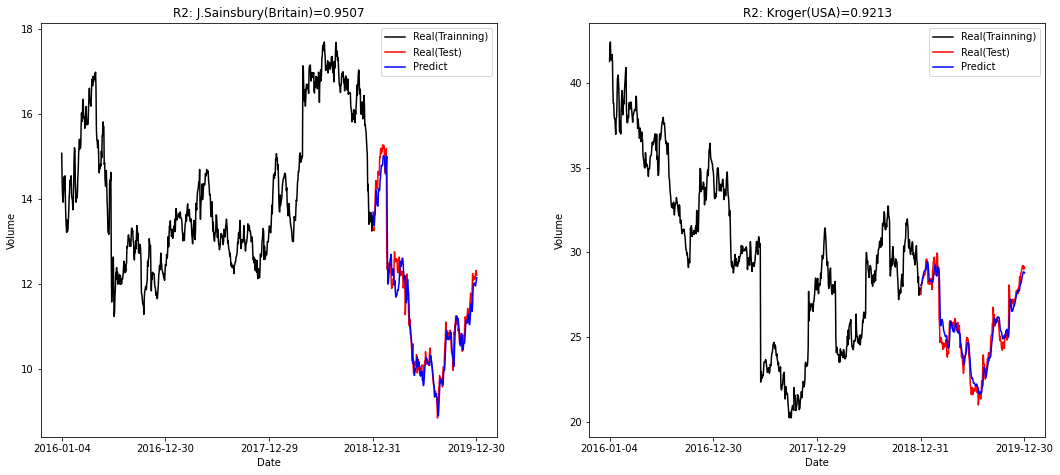

R2-2companies_average=0.936
R2_scores_lists=[0.9507, 0.9213, 0.936]

4回目
[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Carrefour(France)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.4806
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1544
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1268
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1191
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1081
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0986
Epoch 7/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0

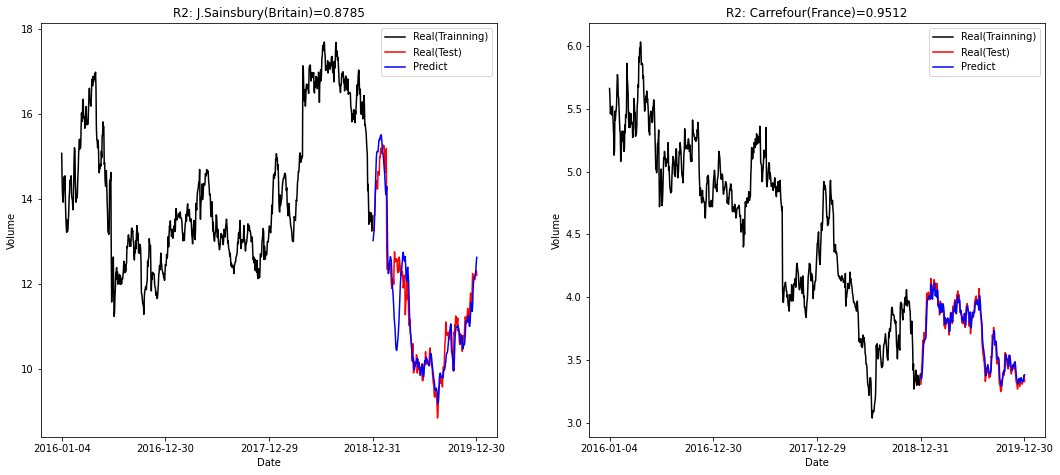

R2-2companies_average=0.9149
R2_scores_lists=[0.8785, 0.9512, 0.9149]

5回目
[Arguments]
num_company=2社 ['Metro (Canada)', 'J.Sainsbury(Britain)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 6s 21ms/step - loss: 0.4628
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1858
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1993
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1530
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1484
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1532
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.12

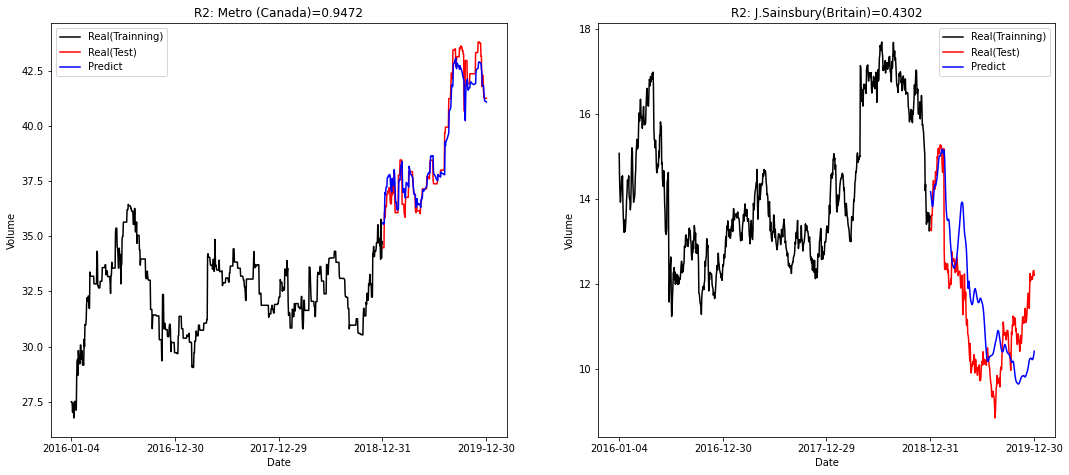

R2-2companies_average=0.6887
R2_scores_lists=[0.9472, 0.4302, 0.6887]

6回目
[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 6s 22ms/step - loss: 0.4963
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1333
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1517
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1249
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1114
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1188
Epoch 7/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0963


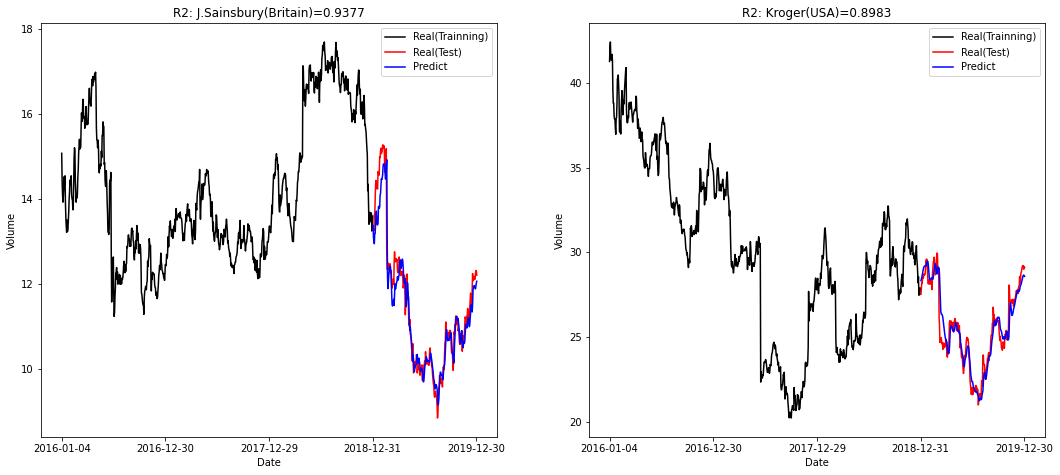

R2-2companies_average=0.918
R2_scores_lists=[0.9377, 0.8983, 0.918]

7回目
[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.4537
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1674
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1455
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1090
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1076
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1018
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1010
Ep

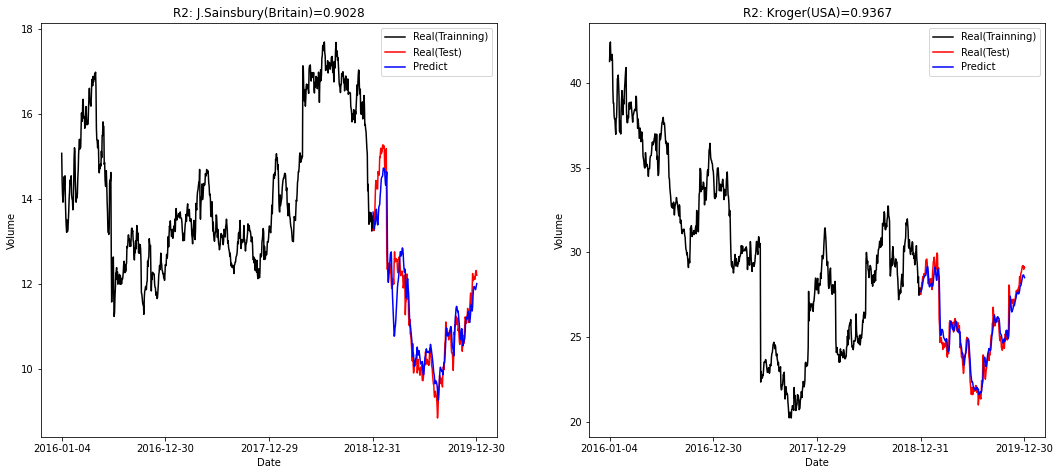

R2-2companies_average=0.9197
R2_scores_lists=[0.9028, 0.9367, 0.9197]

8回目
[Arguments]
num_company=2社 ['George Weston(Canada)', 'Coop Group (Switzerland)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.4691
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1303
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1409
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1076
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1011
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0935
Epoch 7/50
22/22 [==============================] - 0s 15ms/step -

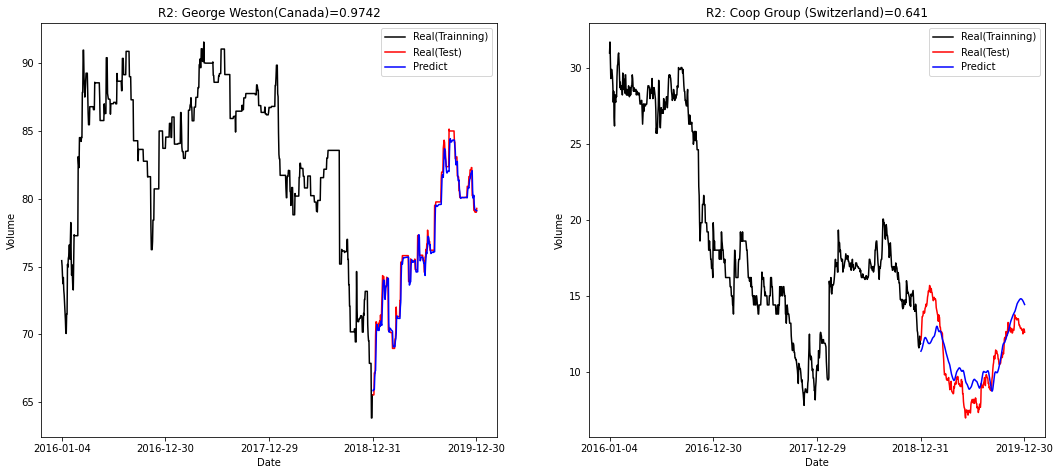

R2-2companies_average=0.8076
R2_scores_lists=[0.9742, 0.641, 0.8076]

9回目
[Arguments]
num_company=2社 ['Tesco(Britain)', 'Seven & I Holdings (Japan)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 7s 24ms/step - loss: 0.3837
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1205
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1066
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0783
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0706
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0806
Epoch 7/50
22/22 [==============================] - 0s 16ms/step - loss:

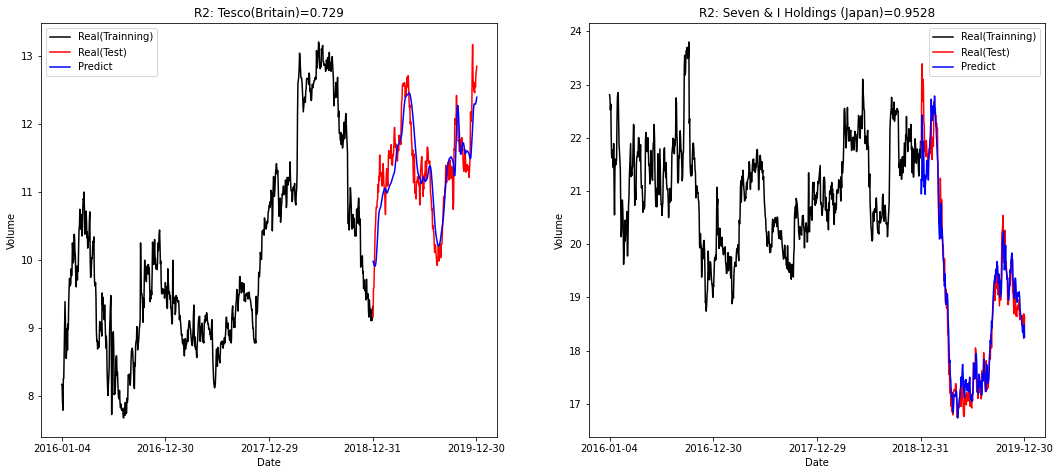

R2-2companies_average=0.8409
R2_scores_lists=[0.729, 0.9528, 0.8409]

10回目
[Arguments]
num_company=2社 ['AEON(Japan)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
training_set_all=(754, 2)
[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 6s 23ms/step - loss: 0.2945
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0658
Epoch 3/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0567
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0519
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0436
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0432
Epoch 7/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0329
Epoch 8/5

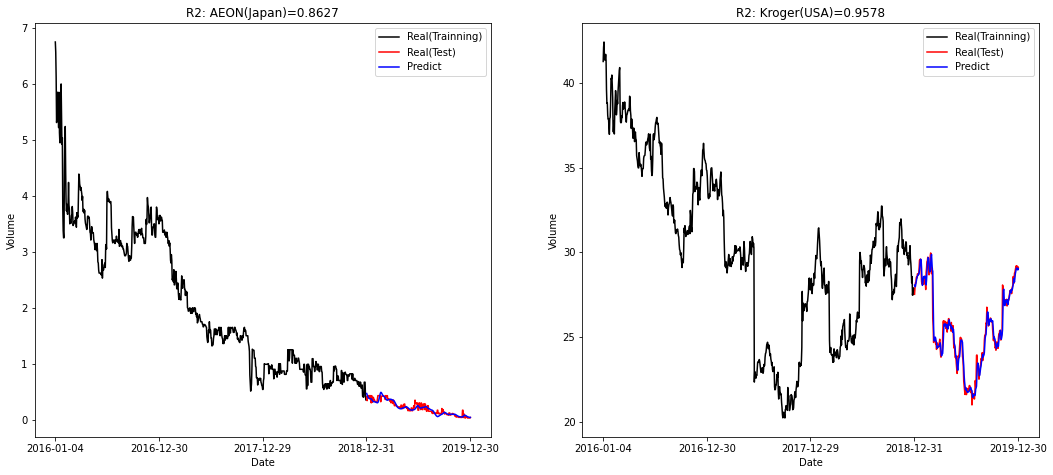

R2-2companies_average=0.9103
R2_scores_lists=[0.8627, 0.9578, 0.9103]



In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=2, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=2, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

1回目
[Arguments]
num_company=3社 ['Kroger(USA)', 'J.Sainsbury(Britain)', 'George Weston(Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 6s 20ms/step - loss: 0.3720
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1151
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0936
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0686
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0713
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0750
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0573
Epoch 8/50
22/22 [=========================

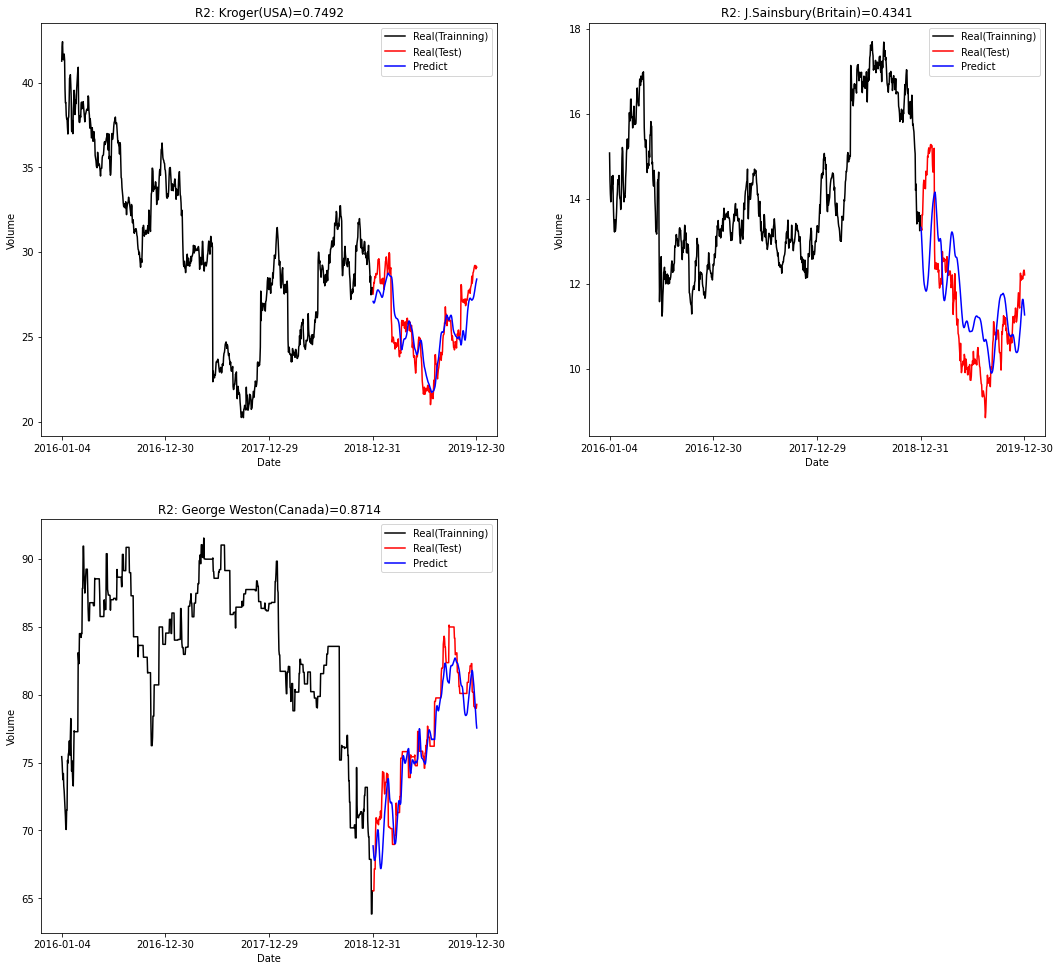

R2-3companies_average=0.6849
R2_scores_lists=[0.7492, 0.4341, 0.8714, 0.6849]

2回目
[Arguments]
num_company=3社 ['Coop Group (Switzerland)', 'Seven & I Holdings (Japan)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 6s 21ms/step - loss: 0.3020
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0780
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0543
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0506
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0398
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0420
Epoch 7/50
22/22 [=================

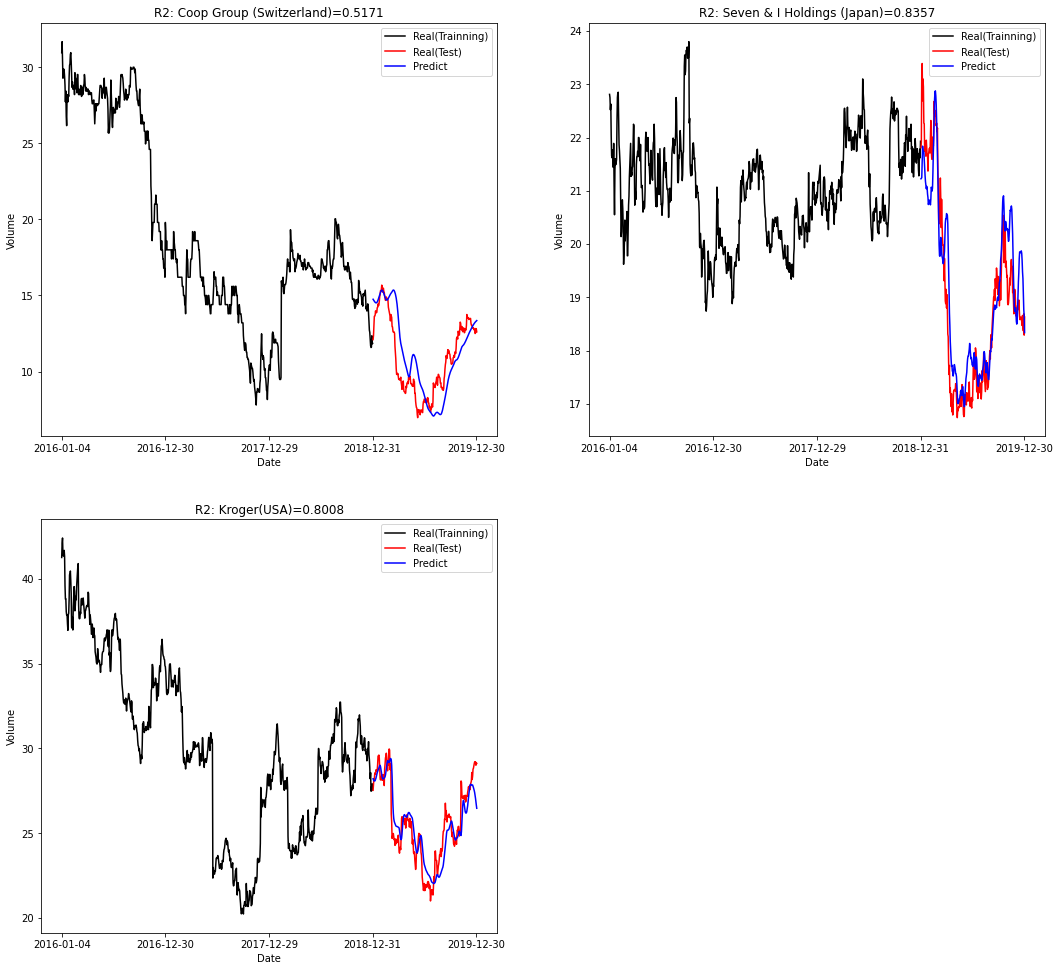

R2-3companies_average=0.7179
R2_scores_lists=[0.5171, 0.8357, 0.8008, 0.7179]

3回目
[Arguments]
num_company=3社 ['J.Sainsbury(Britain)', 'Carrefour(France)', 'Coop Group (Switzerland)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.5290
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1313
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1387
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1130
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0868
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1049
Epoch 7/50
22/22 [=================

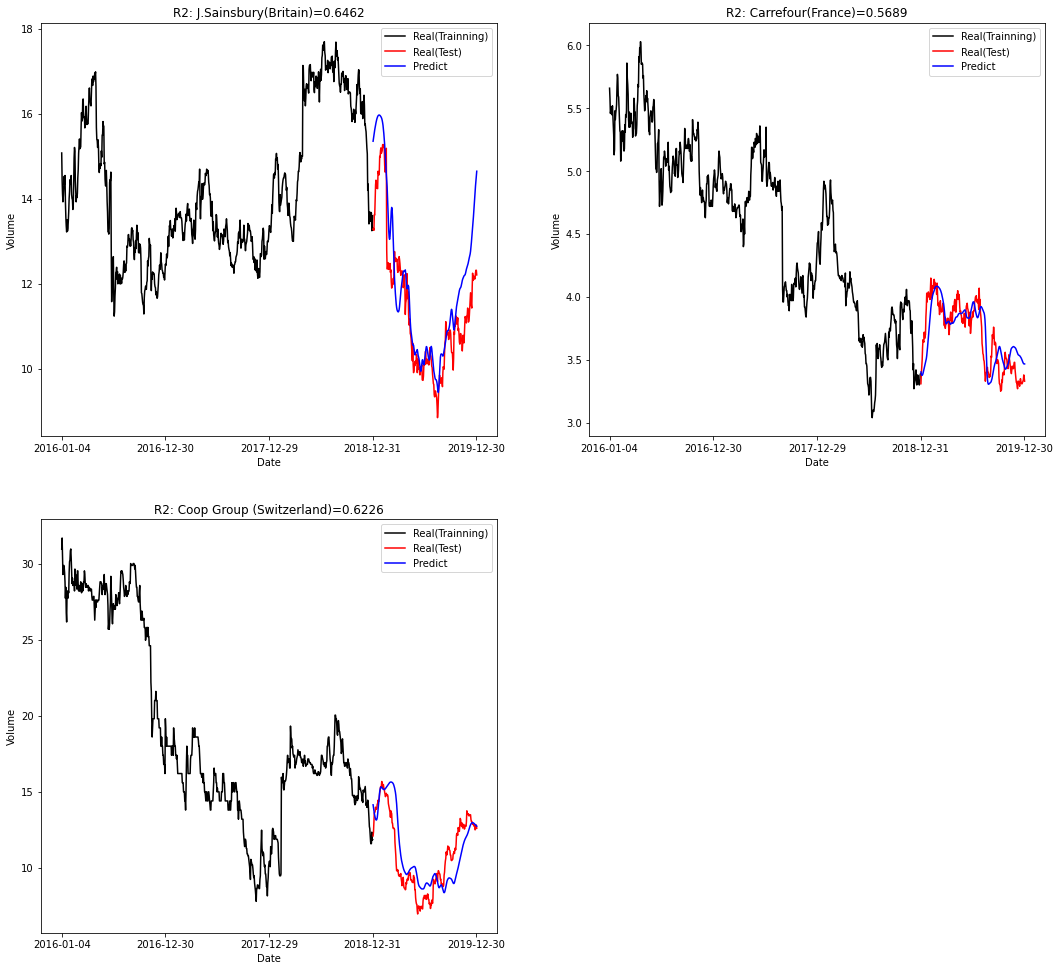

R2-3companies_average=0.6125
R2_scores_lists=[0.6462, 0.5689, 0.6226, 0.6125]

4回目
[Arguments]
num_company=3社 ['Kroger(USA)', 'Tesco(Britain)', 'AEON(Japan)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 21ms/step - loss: 0.3170
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1201
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0815
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0711
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0602
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0655
Epoch 7/50
22/22 [==============================] - 0s 14ms/

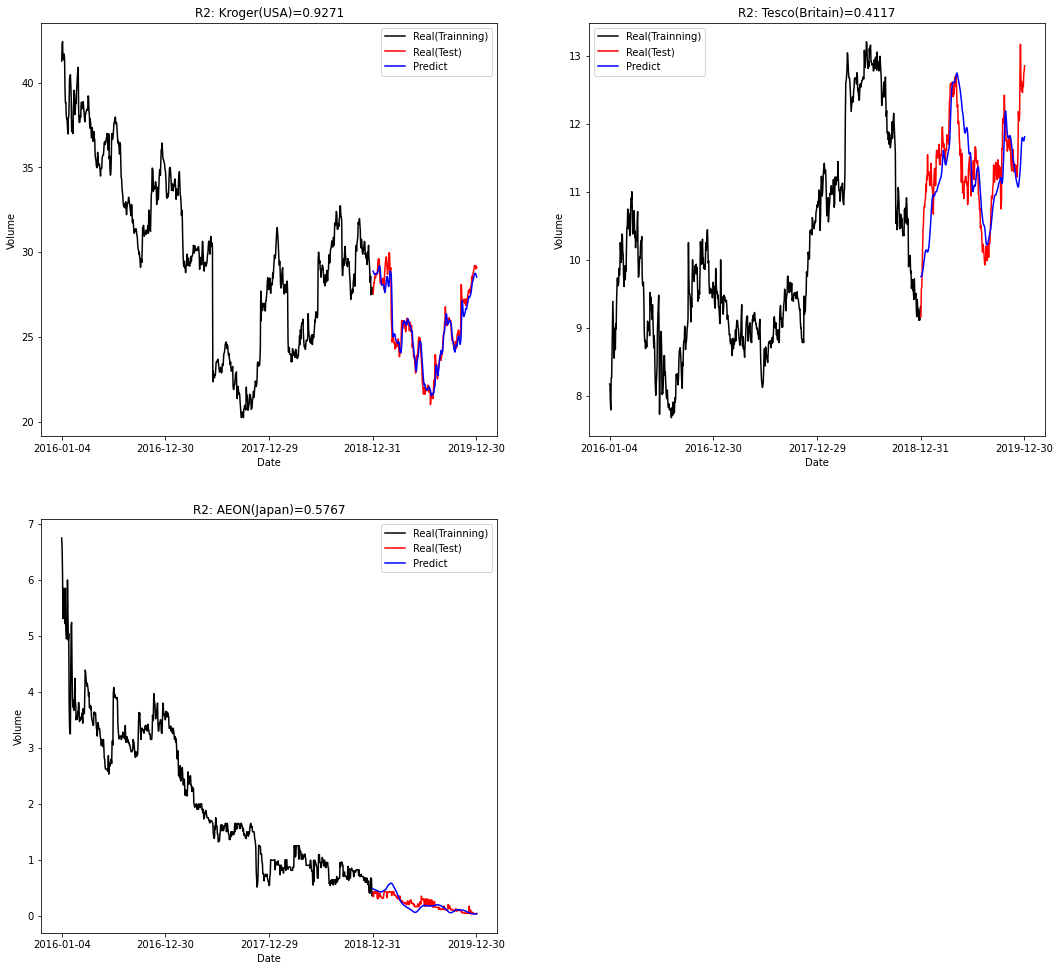

R2-3companies_average=0.6385
R2_scores_lists=[0.9271, 0.4117, 0.5767, 0.6385]

5回目
[Arguments]
num_company=3社 ['AEON(Japan)', 'Metro (Canada)', 'Carrefour(France)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 6s 21ms/step - loss: 0.2572
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0585
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0530
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0427
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0460
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0390
Epoch 7/50
22/22 [==============================] - 0s

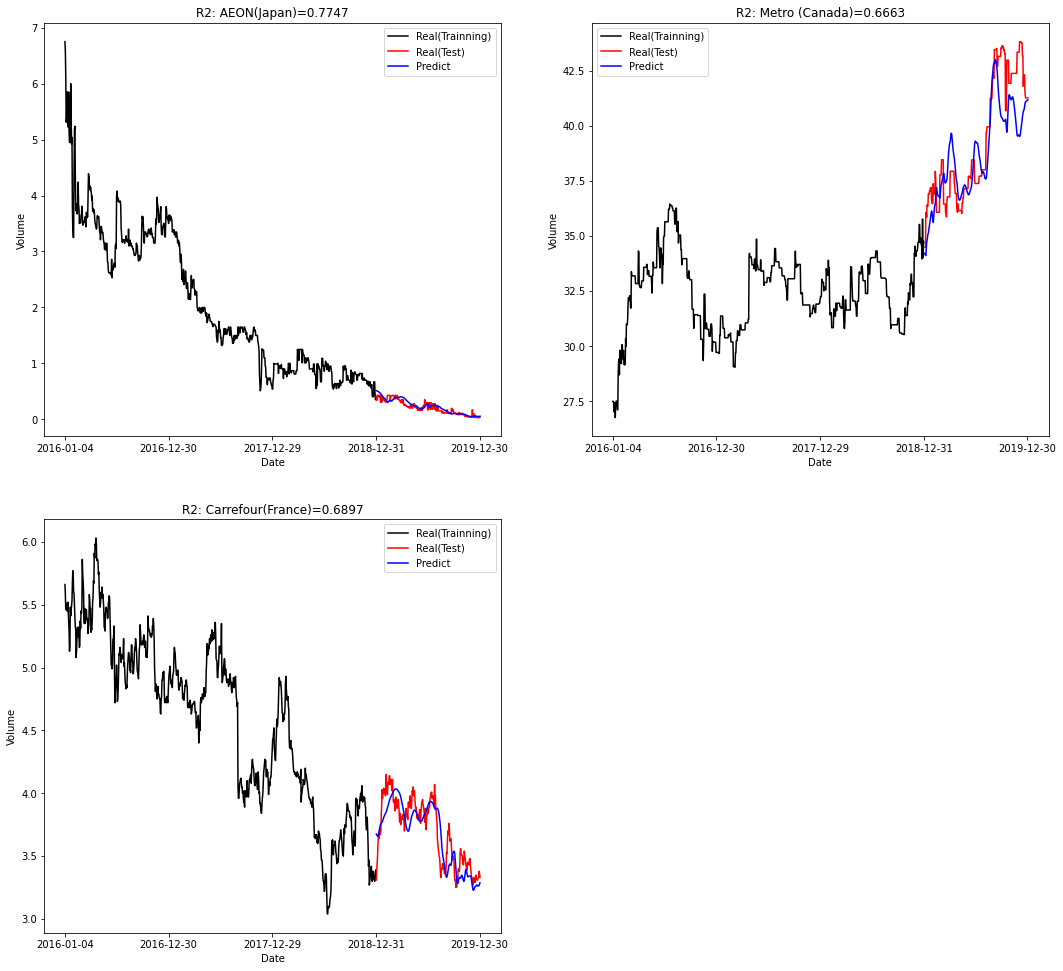

R2-3companies_average=0.7103
R2_scores_lists=[0.7747, 0.6663, 0.6897, 0.7103]

6回目
[Arguments]
num_company=3社 ['AEON(Japan)', 'J.Sainsbury(Britain)', 'Kroger(USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 23ms/step - loss: 0.2913
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0577
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0471
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0534
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0491
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0423
Epoch 7/50
22/22 [==============================] - 0s

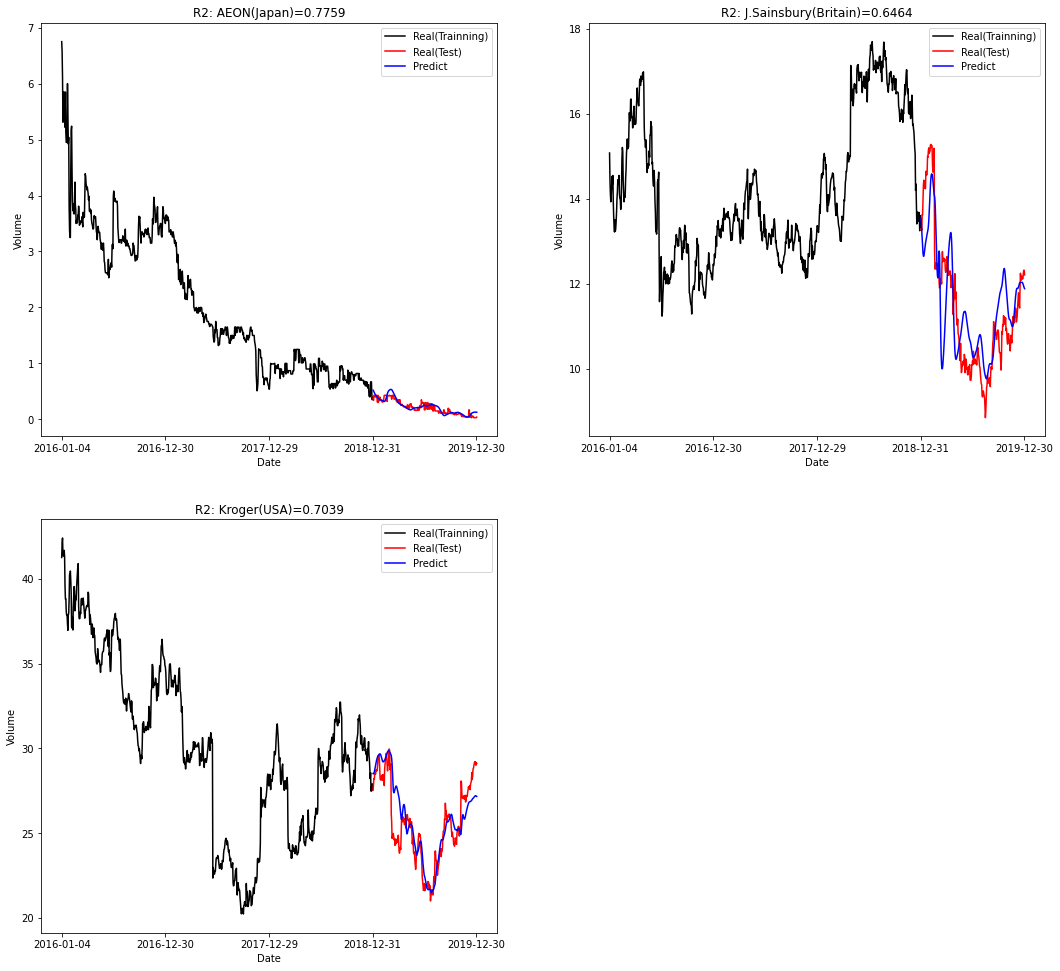

R2-3companies_average=0.7087
R2_scores_lists=[0.7759, 0.6464, 0.7039, 0.7087]

7回目
[Arguments]
num_company=3社 ['AEON(Japan)', 'George Weston(Canada)', 'Metro (Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 22ms/step - loss: 0.3281
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0469
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0441
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0430
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0362
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0325
Epoch 7/50
22/22 [==============================] 

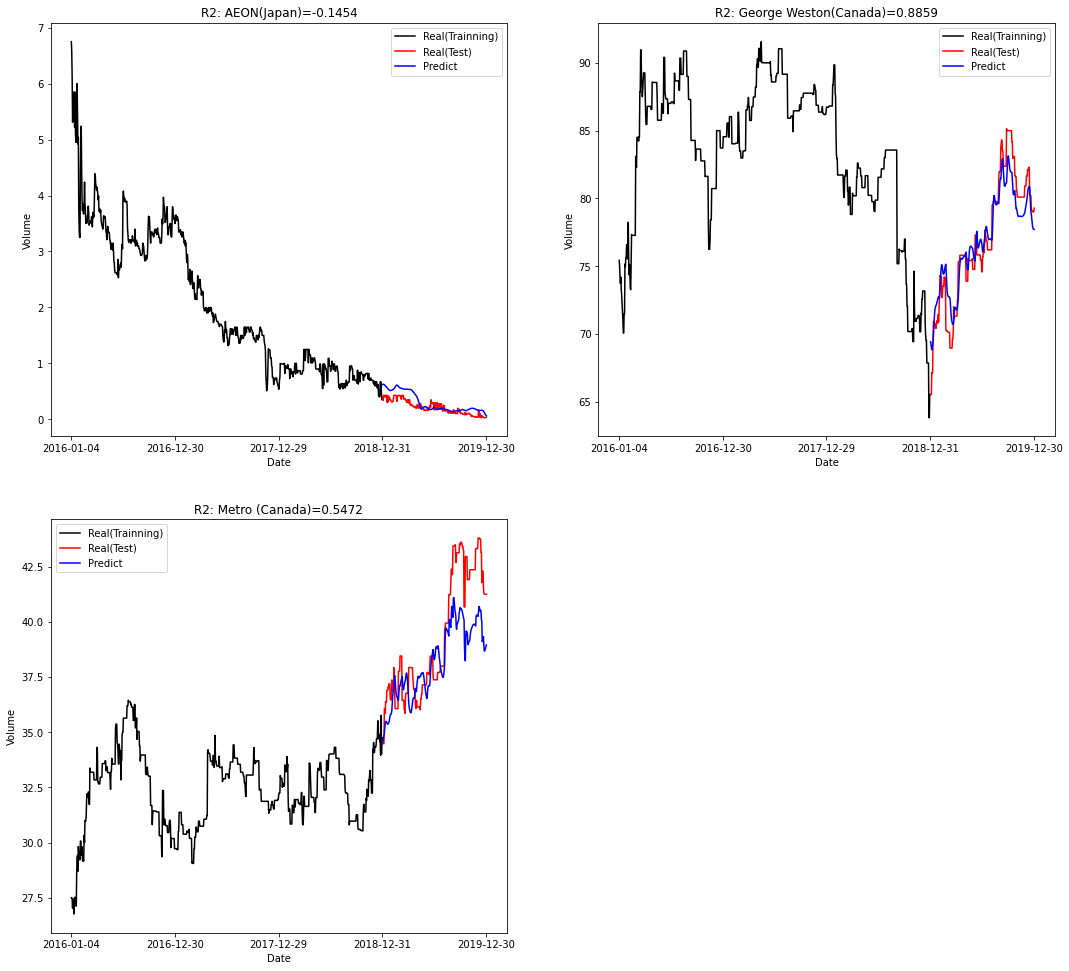

R2-3companies_average=0.4292
R2_scores_lists=[-0.1454, 0.8859, 0.5472, 0.4292]

8回目
[Arguments]
num_company=3社 ['Coop Group (Switzerland)', 'Metro (Canada)', 'George Weston(Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 22ms/step - loss: 0.3986
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0695
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0446
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0389
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0429
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0441
Epoch 7/50
22/22 [==================

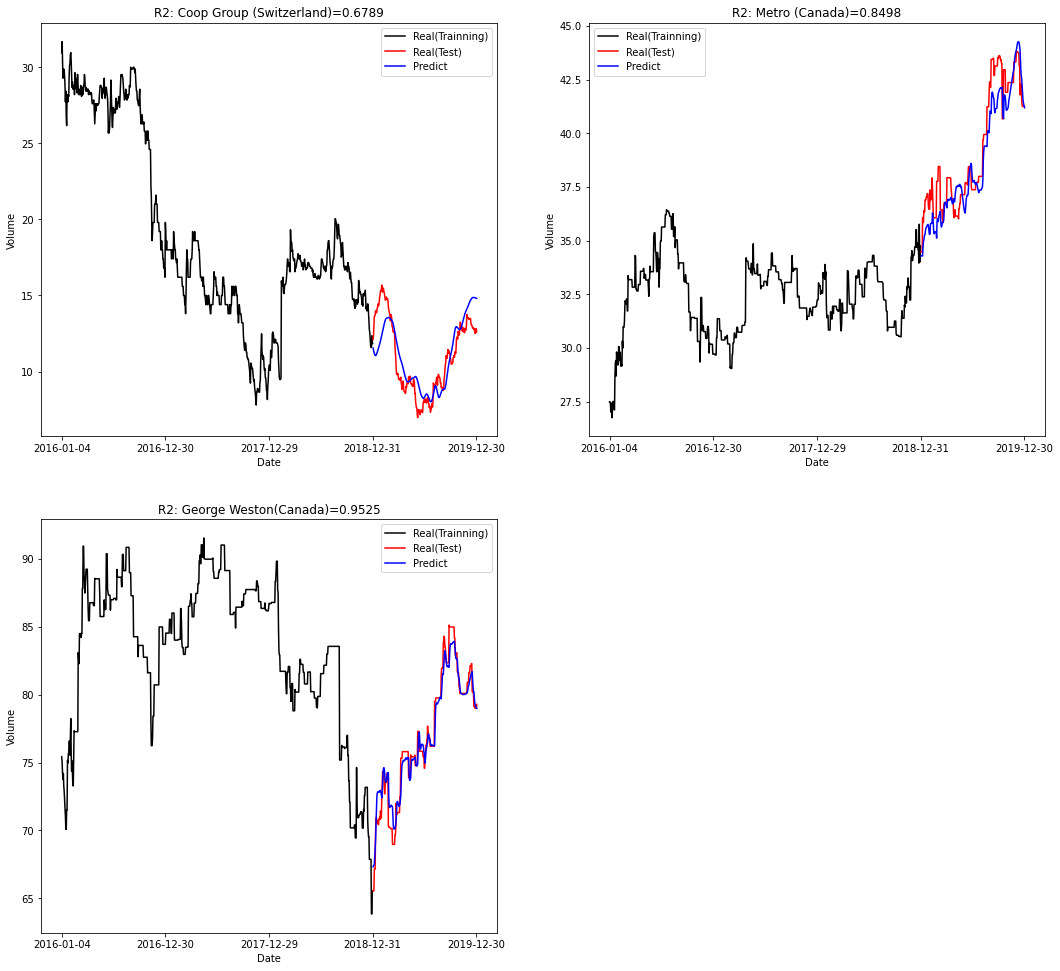

R2-3companies_average=0.8271
R2_scores_lists=[0.6789, 0.8498, 0.9525, 0.8271]

9回目
[Arguments]
num_company=3社 ['Carrefour(France)', 'Coop Group (Switzerland)', 'Royal Ahold Delhaize(Netherlands)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 5s 23ms/step - loss: 0.4192
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1264
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0911
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0988
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0826
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0795
Epoch 7/50
22/22 [====

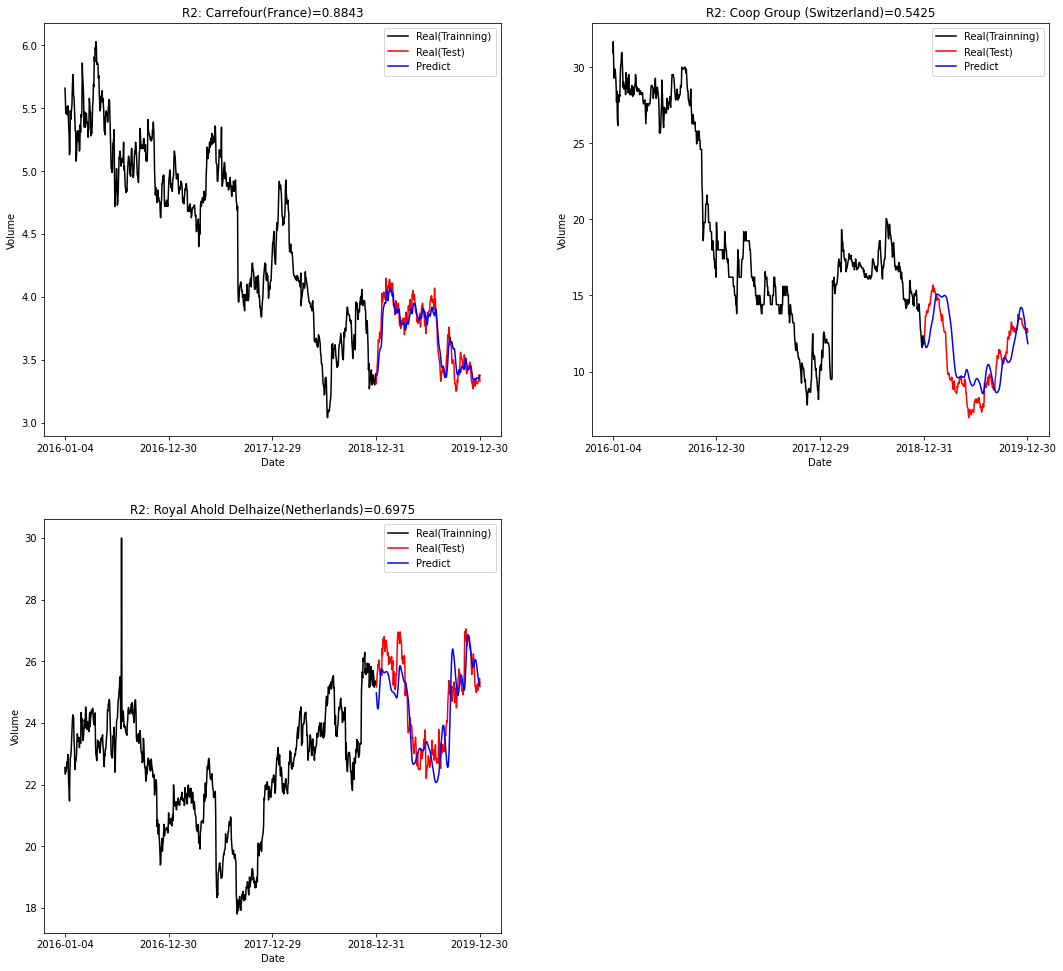

R2-3companies_average=0.7081
R2_scores_lists=[0.8843, 0.5425, 0.6975, 0.7081]

10回目
[Arguments]
num_company=3社 ['Kroger(USA)', 'Carrefour(France)', 'Metro (Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
training_set_all=(754, 3)
[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 6s 25ms/step - loss: 0.3472
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1011
Epoch 3/50
22/22 [==============================] - 0s 18ms/step - loss: 0.0936
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1020
Epoch 5/50
22/22 [==============================] - 0s 19ms/step - loss: 0.0713
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0676
Epoch 7/50
22/22 [==============================] - 0

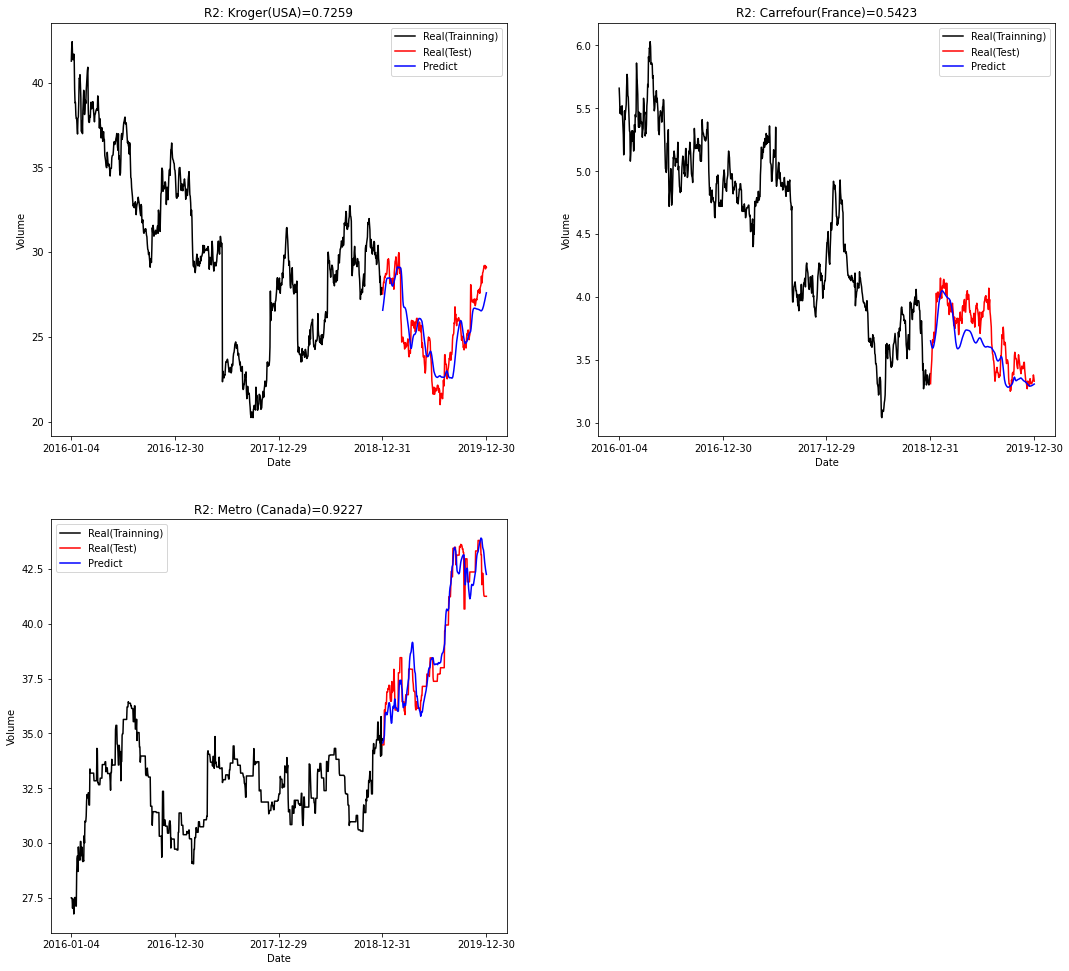

R2-3companies_average=0.7303
R2_scores_lists=[0.7259, 0.5423, 0.9227, 0.7303]



In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=3, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=3, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

1回目
[Arguments]
num_company=4社 ['Tesco(Britain)', 'AEON(Japan)', 'Walgreens Boots Alliance (USA)', 'Carrefour(France)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 19ms/step - loss: 0.3739
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0868
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0709
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0643
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0637
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0572
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0593
Epoch 8/50
22/22

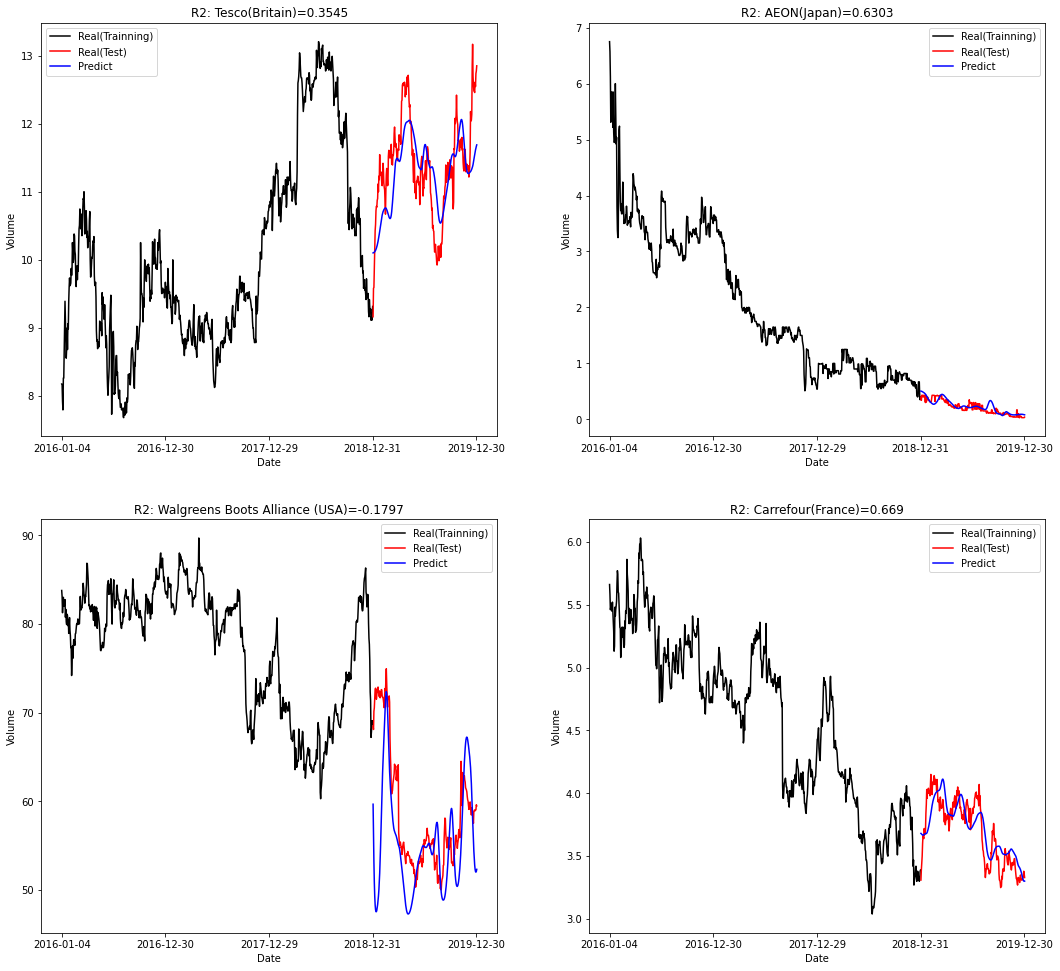

R2-4companies_average=0.3685
R2_scores_lists=[0.3545, 0.6303, -0.1797, 0.669, 0.3685]

2回目
[Arguments]
num_company=4社 ['Kroger(USA)', 'Seven & I Holdings (Japan)', 'Royal Ahold Delhaize(Netherlands)', 'Coop Group (Switzerland)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.3059
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0939
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0730
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0709
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0582
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - 

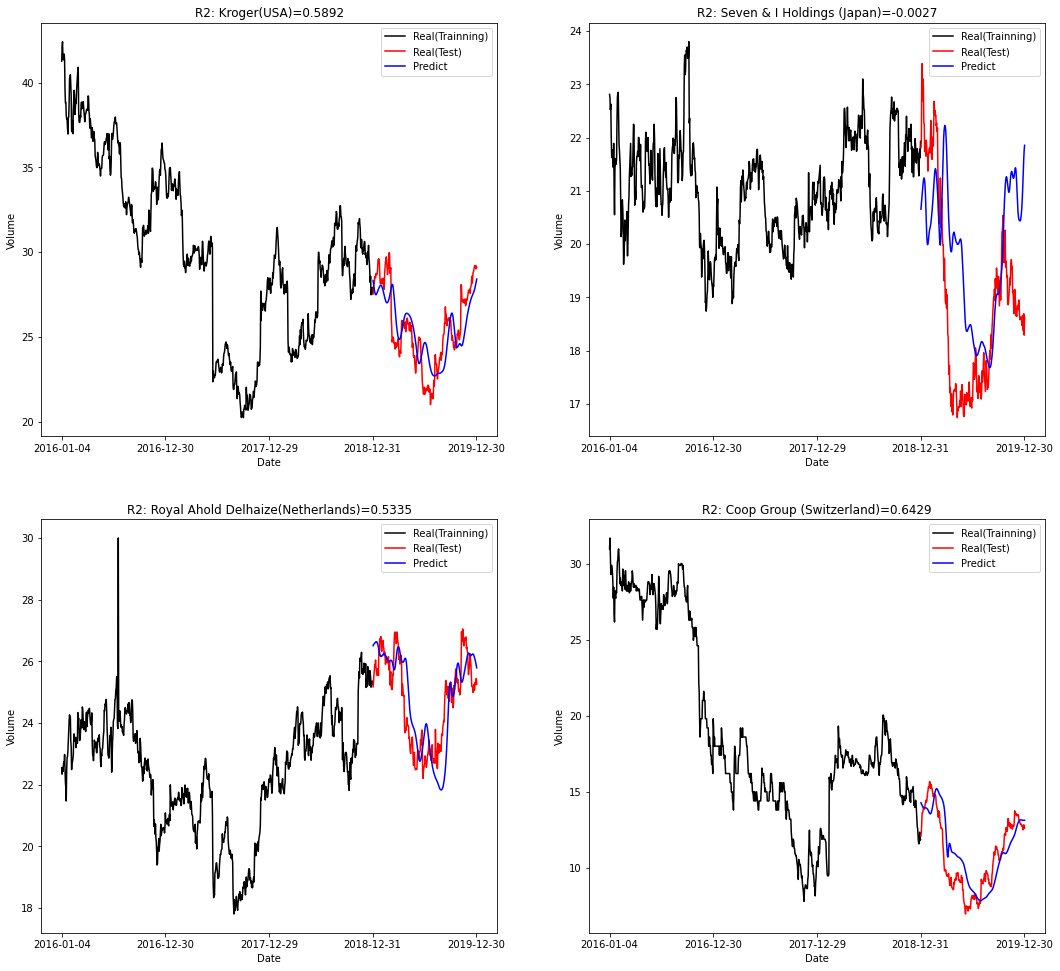

R2-4companies_average=0.4407
R2_scores_lists=[0.5892, -0.0027, 0.5335, 0.6429, 0.4407]

3回目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'Seven & I Holdings (Japan)', 'Tesco(Britain)', 'J.Sainsbury(Britain)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.5302
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.2091
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1760
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1112
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0999
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - 

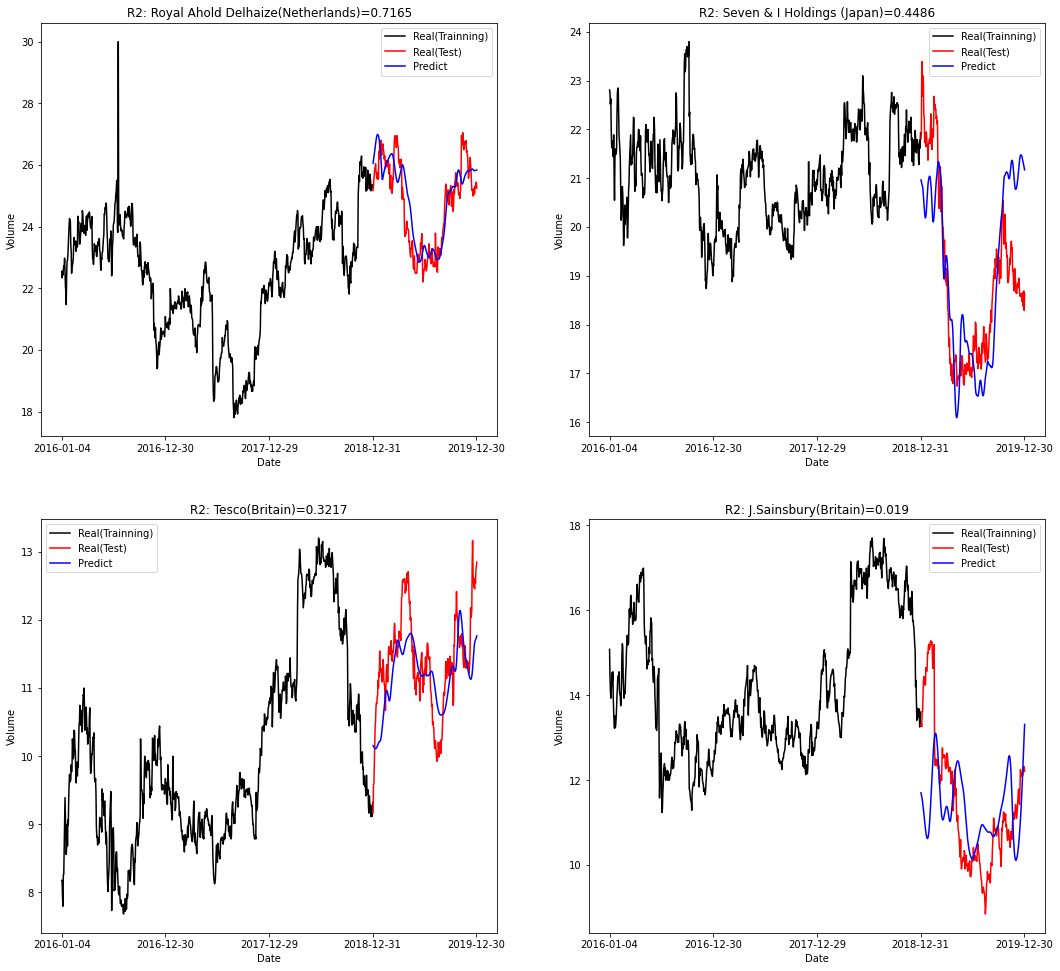

R2-4companies_average=0.3764
R2_scores_lists=[0.7165, 0.4486, 0.3217, 0.019, 0.3764]

4回目
[Arguments]
num_company=4社 ['George Weston(Canada)', 'Kroger(USA)', 'Coop Group (Switzerland)', 'Royal Ahold Delhaize(Netherlands)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 22ms/step - loss: 0.4446
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1389
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1272
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1025
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0857
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 

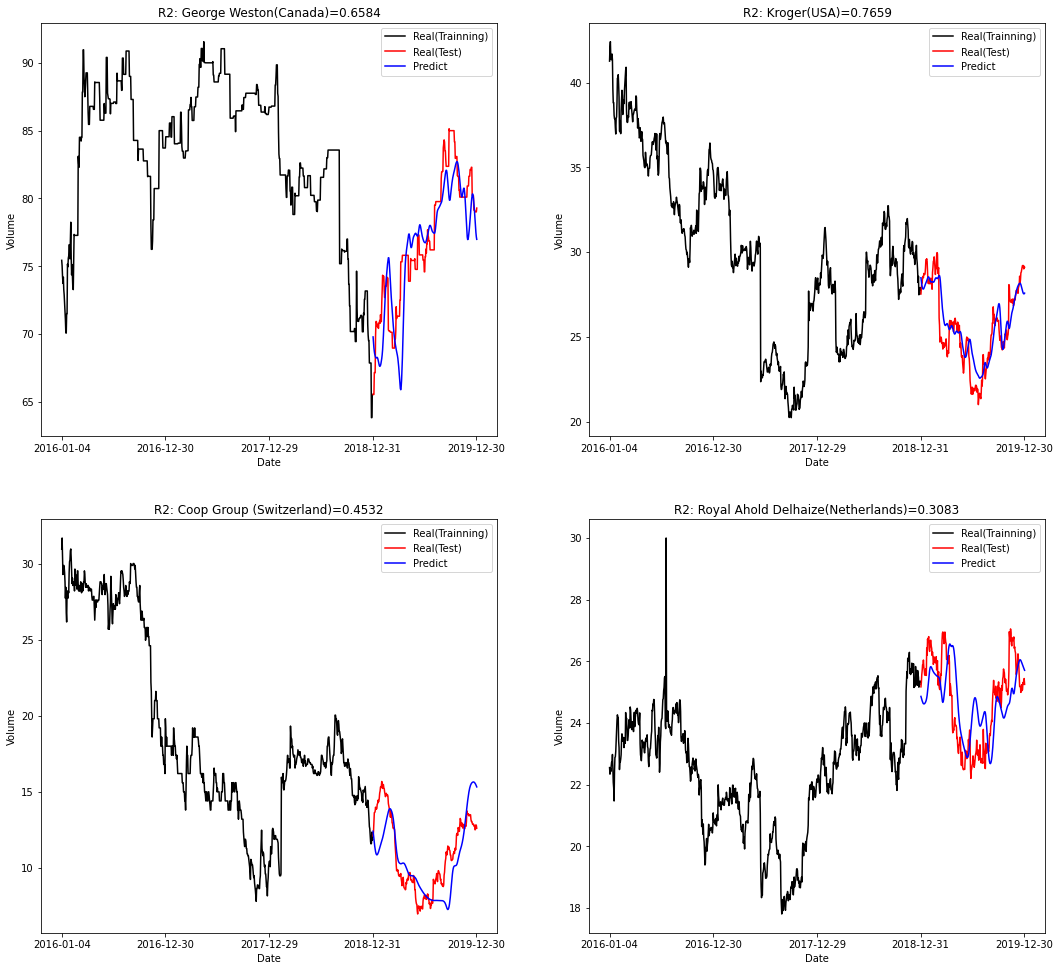

R2-4companies_average=0.5465
R2_scores_lists=[0.6584, 0.7659, 0.4532, 0.3083, 0.5465]

5回目
[Arguments]
num_company=4社 ['George Weston(Canada)', 'Carrefour(France)', 'Royal Ahold Delhaize(Netherlands)', 'Walgreens Boots Alliance (USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 22ms/step - loss: 0.4013
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1410
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1177
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1089
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0964
Epoch 6/50
22/22 [==============================] - 0s 17ms/

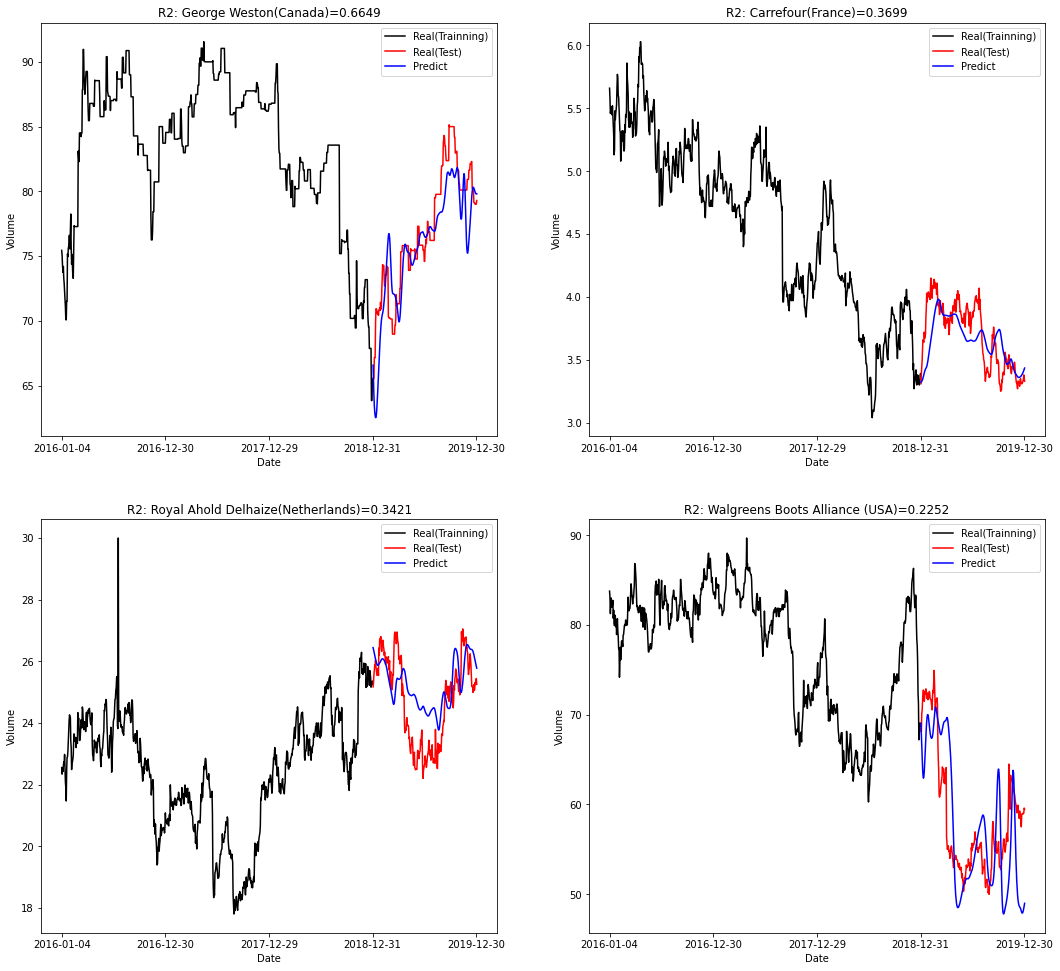

R2-4companies_average=0.4005
R2_scores_lists=[0.6649, 0.3699, 0.3421, 0.2252, 0.4005]

6回目
[Arguments]
num_company=4社 ['Carrefour(France)', 'J.Sainsbury(Britain)', 'Kroger(USA)', 'Tesco(Britain)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 22ms/step - loss: 0.3841
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1127
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0920
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0799
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0704
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0656
Epoch 7/50
22/22 [=

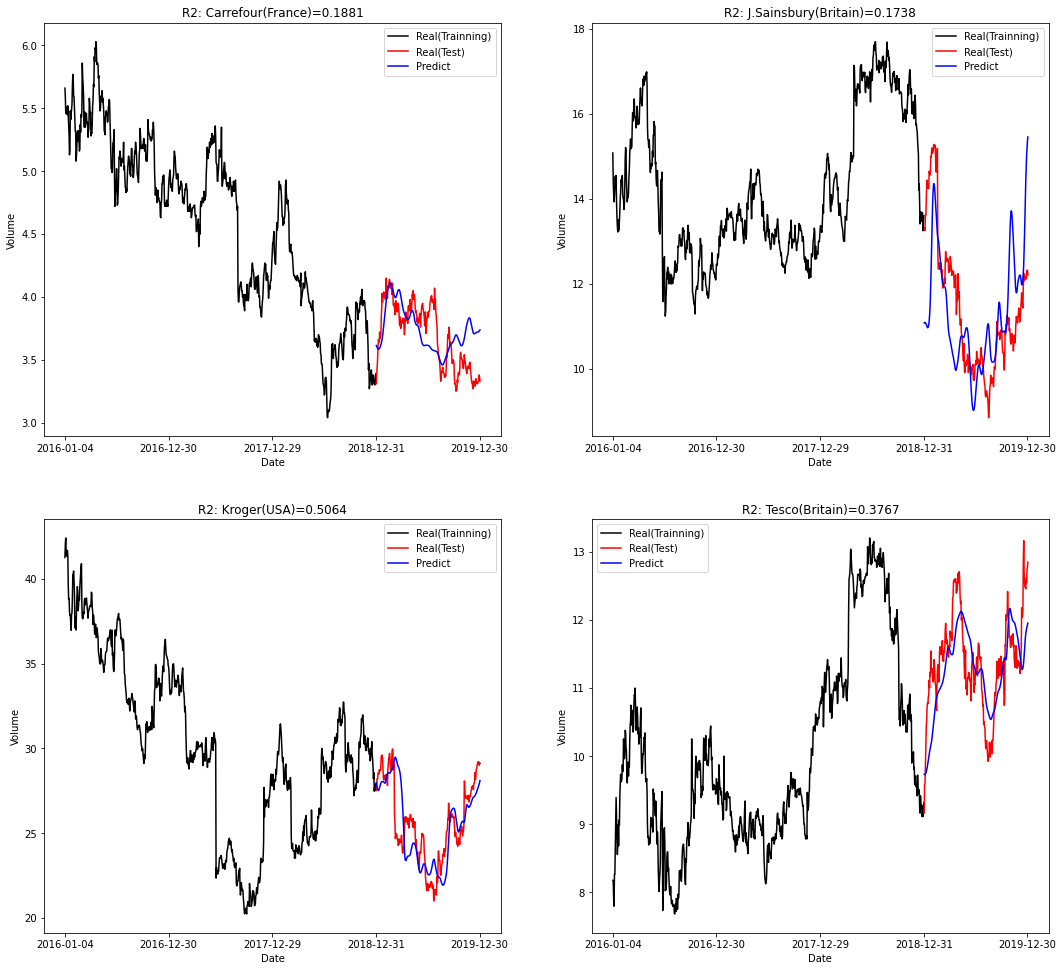

R2-4companies_average=0.3112
R2_scores_lists=[0.1881, 0.1738, 0.5064, 0.3767, 0.3112]

7回目
[Arguments]
num_company=4社 ['J.Sainsbury(Britain)', 'Kroger(USA)', 'Coop Group (Switzerland)', 'Walgreens Boots Alliance (USA)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 6s 23ms/step - loss: 0.5112
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1417
Epoch 3/50
22/22 [==============================] - 0s 18ms/step - loss: 0.1116
Epoch 4/50
22/22 [==============================] - 0s 18ms/step - loss: 0.1132
Epoch 5/50
22/22 [==============================] - 0s 19ms/step - loss: 0.0927
Epoch 6/50
22/22 [==============================] - 0s 18ms/step - loss: 0.0

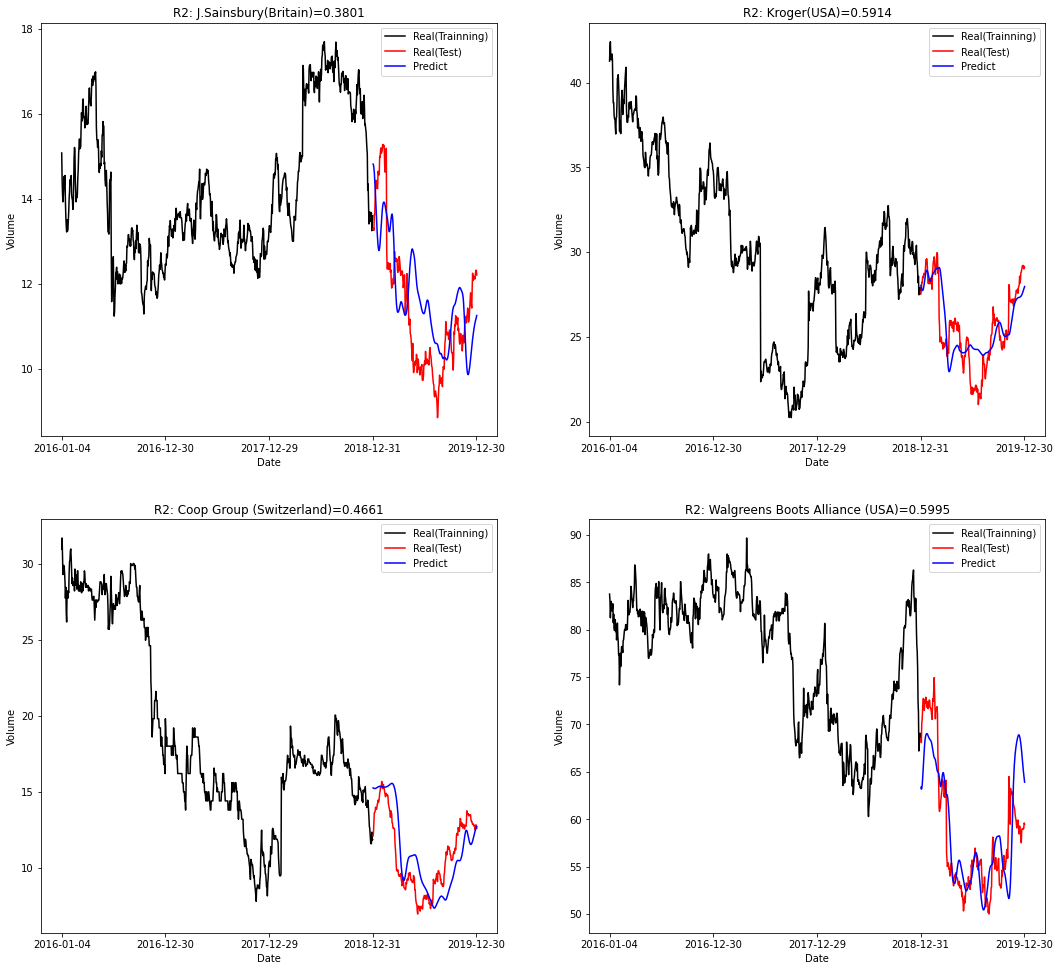

R2-4companies_average=0.5093
R2_scores_lists=[0.3801, 0.5914, 0.4661, 0.5995, 0.5093]

8回目
[Arguments]
num_company=4社 ['Tesco(Britain)', 'Walgreens Boots Alliance (USA)', 'Carrefour(France)', 'J.Sainsbury(Britain)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 7s 24ms/step - loss: 0.4043
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0922
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0737
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0620
Epoch 5/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0708
Epoch 6/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0637


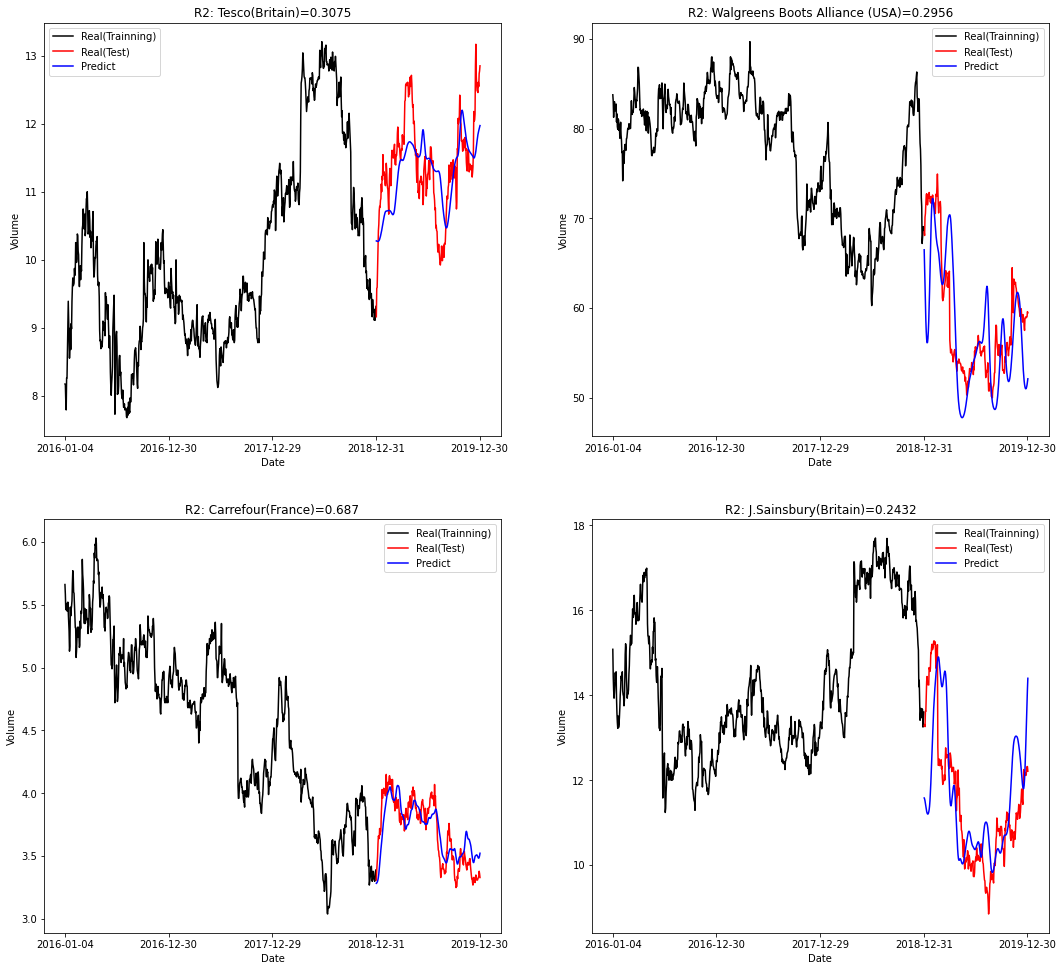

R2-4companies_average=0.3833
R2_scores_lists=[0.3075, 0.2956, 0.687, 0.2432, 0.3833]

9回目
[Arguments]
num_company=4社 ['AEON(Japan)', 'Carrefour(France)', 'Metro (Canada)', 'George Weston(Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 23ms/step - loss: 0.3163
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0571
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0463
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0404
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0315
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0310
Epoch 7/50
22/22 [=

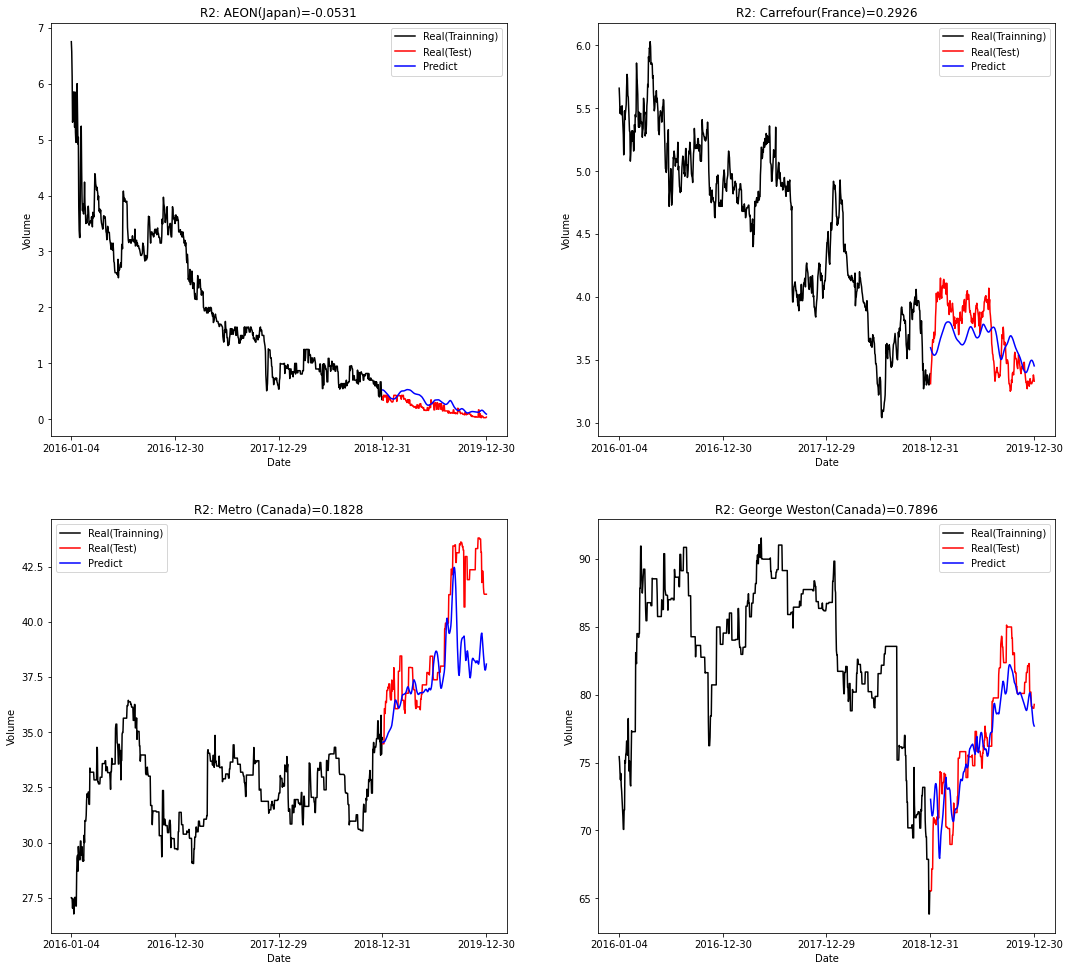

R2-4companies_average=0.303
R2_scores_lists=[-0.0531, 0.2926, 0.1828, 0.7896, 0.303]

10回目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'Metro (Canada)', 'AEON(Japan)', 'George Weston(Canada)']
input_variables=['High'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
training_set_all=(754, 4)
[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.5346
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1878
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1313
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1077
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1288
Epoch 6/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1039
Ep

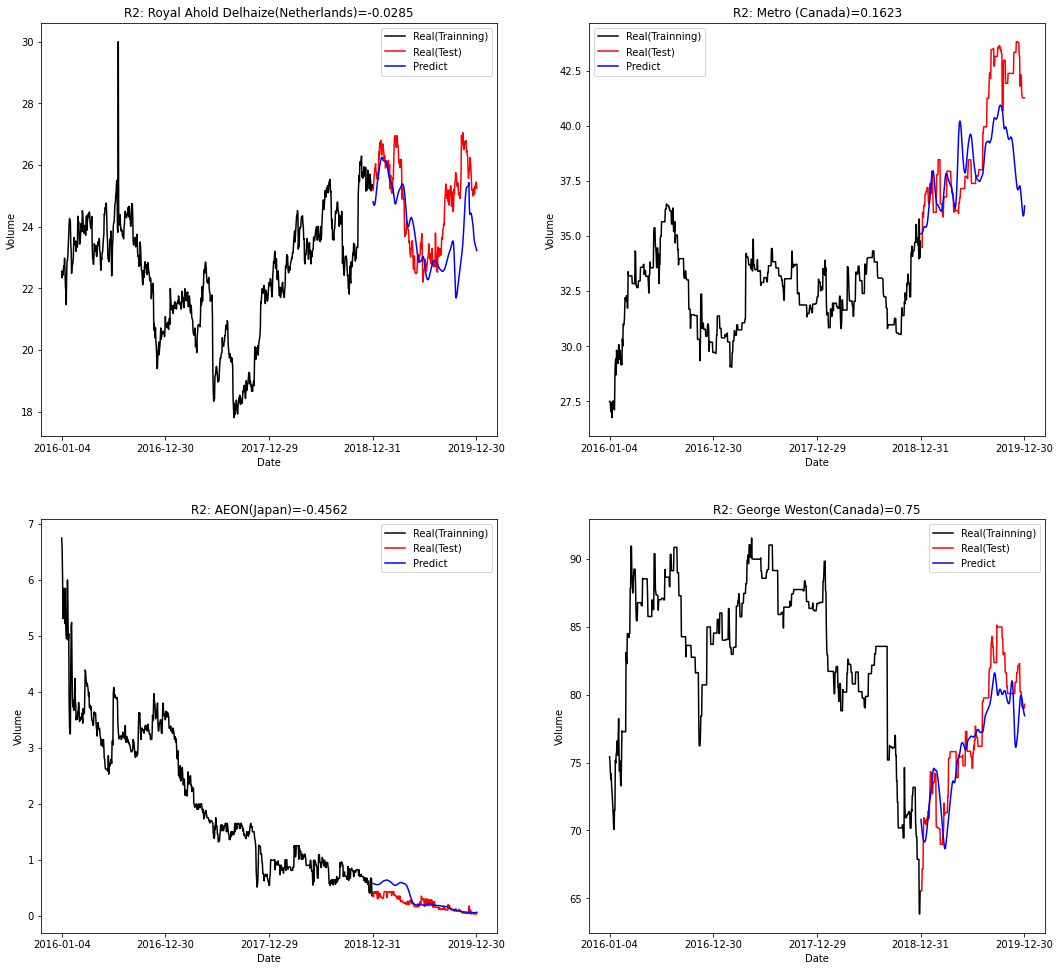

R2-4companies_average=0.1069
R2_scores_lists=[-0.0285, 0.1623, -0.4562, 0.75, 0.1069]



In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=4, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=4, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=5, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=5, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=6, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=6, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=7, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=7, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

# Result (High -> High)

In [ ]:
import matplotlib.pyplot as plt
# experiment data
R2=[0.8768, 0.8258, 0.936, 0.9149, 0.6887, 0.918, 0.9197, 0.8076, 0.8409, 0.9103]
R3=[0.6849,  0.7179, 0.6125, 0.6385, 0.7103, 0.7087, 0.4292, 0.8271,  0.7081, 0.7303]
R4=[0.3685, 0.4407, 0.3764, 0.5465, 0.4005, 0.3112, 0.5093, 0.3833, 0.303, 0.1069]
R5=[0.3472, 0.4567, 0.223, 0.3749, 0.3356, 0.3154]
R6=[]
R7=[]
R2_scores=(R2, R3, R4, R5, R6, R7)
fix, ax = plt.subplots()
boxplots = ax.boxplot(R2_scores)
ax.set_xticklabels(['n=2', 'n=3', 'n=4', 'n=5', 'n=6', 'n=7'])
plt.title('R2-BOXPLOT[High]')
plt.grid()
plt.show()